# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://eva.fing.edu.uy/mod/page/view.php?id=69213) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


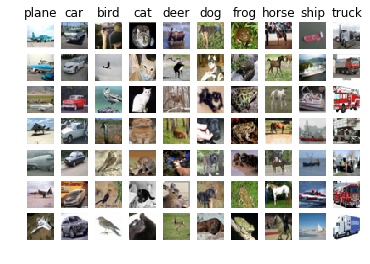

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print( 'Train data shape: ', X_train.shape )
print( 'Train labels shape: ', y_train.shape )
print( 'Validation data shape: ', X_val.shape )
print( 'Validation labels shape: ', y_val.shape )
print( 'Test data shape: ', X_test.shape )
print( 'Test labels shape: ', y_test.shape )

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape )
print( 'Validation data shape: ', X_val.shape )
print( 'Test data shape: ', X_test.shape )
print( 'dev data shape: ', X_dev.shape )

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


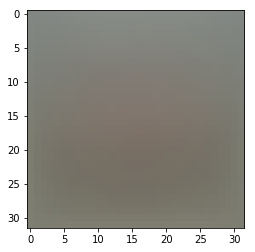

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SoftMax
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 

*TODO_OURS* As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SoftMax loss function. 

In [10]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.softmax import softmax_loss_naive
import time

# generate a random SoftMax weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
print( 'loss: %f' % (loss, ) )
print('sanity check: %f' % -np.log(0.1))

loss: 2.347709
sanity check: 2.302585


### Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.

**Your answer:** Por que W es muy chico entonces la funcion loss = -log(1/c)

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the Softmax cost function and implement it inline inside the function `softmax_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [11]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.361965 analytic: 0.361965, relative error: 1.709718e-07
numerical: 0.346045 analytic: 0.346045, relative error: 1.240286e-07
numerical: -1.751339 analytic: -1.751339, relative error: 1.471583e-09
numerical: 1.181643 analytic: 1.181643, relative error: 1.742345e-08
numerical: -1.595078 analytic: -1.595078, relative error: 2.046954e-08
numerical: -2.992656 analytic: -2.992656, relative error: 9.587529e-09
numerical: 0.864801 analytic: 0.864801, relative error: 3.774193e-08
numerical: -3.279038 analytic: -3.279038, relative error: 6.955550e-09
numerical: -0.379120 analytic: -0.379120, relative error: 3.837889e-08
numerical: -1.428208 analytic: -1.428208, relative error: 1.723235e-08
numerical: 0.184796 analytic: 0.184796, relative error: 4.955492e-08
numerical: 1.814289 analytic: 1.814288, relative error: 2.322251e-08
numerical: -0.978542 analytic: -0.978542, relative error: 1.010733e-08
numerical: 0.134969 analytic: 0.134969, relative error: 9.899522e-08
numerical: 6.146889 

In [12]:
# Next implement the function softmax_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, _ = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

naive loss: 2.347709e+00 computed in 0.183000s
vectorized loss: 2.347709e+00 computed in 0.001000s
difference: -0.000000


In [13]:
# Complete the implementation of softmax_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.179400s
Vectorized loss and gradient: computed in 0.000000s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [14]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()

loss_hist, W = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 785.829788
iteration 100 / 1500: loss 288.514794
iteration 200 / 1500: loss 106.826384
iteration 300 / 1500: loss 40.379716
iteration 400 / 1500: loss 16.136797
iteration 500 / 1500: loss 7.251756
iteration 600 / 1500: loss 4.005762
iteration 700 / 1500: loss 2.767342
iteration 800 / 1500: loss 2.350167
iteration 900 / 1500: loss 2.237722
iteration 1000 / 1500: loss 2.119328
iteration 1100 / 1500: loss 2.074314
iteration 1200 / 1500: loss 2.111170
iteration 1300 / 1500: loss 2.087580
iteration 1400 / 1500: loss 2.050841
That took 7.518200s


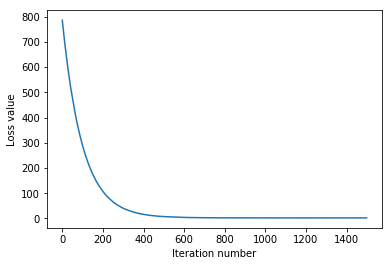

In [15]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [16]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print( 'training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print( 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
#y_test_pred = softmax.predict(X_test)
#print( 'validation accuracy: %f' % (np.mean(y_test == y_test_pred), ))

training accuracy: 0.329653
validation accuracy: 0.346000


In [19]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.35 on the validation set.
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a SoftMax    on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the SoftMax object that achieves this    #
# accuracy in best_softmax.                                                    #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your valid.  #
# code so that the Softmax don't take much time to train; once you are         #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

for lr in learning_rates:
    for rs in regularization_strengths:
        results[(lr,rs)] = []
        softmax = Softmax()
        loss_hist, W = softmax.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1000, verbose=False)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = (np.mean(y_train == y_train_pred))
        y_val_pred = softmax.predict(X_val)
        val_accuracy =  (np.mean(y_val == y_val_pred))
        results[(lr,rs)] = (train_accuracy,val_accuracy)
        if(val_accuracy > best_val):
            best_val = val_accuracy
            best_softmax = softmax
        

#pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

D:\Desarrollo\fing\assignment1\cs231n\classifiers\softmax.py:105: RuntimeWarning: invalid value encountered in true_divide
  s = np.exp(scores) / sj
D:\Desarrollo\fing\assignment1\cs231n\classifiers\softmax.py:106: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(s[np.arange(num_train),y]))


lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.325388 val accuracy: 0.346000
lr 1.000000e-07 reg 1.000000e+08 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.330633 val accuracy: 0.343000
lr 5.000000e-07 reg 1.000000e+08 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.346000


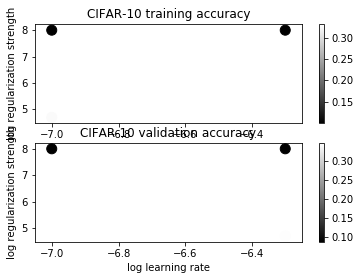

In [20]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [21]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('SoftMax on raw pixels final test set accuracy: %f' % test_accuracy)

SoftMax on raw pixels final test set accuracy: 0.337000


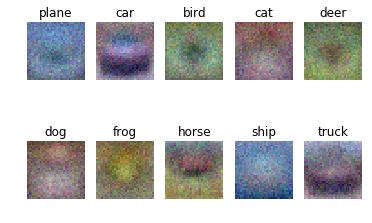

In [22]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized Softmax weights look like, and offer a brief explanation for why they look the way that they do.

**Your answer:** El clasificador lineal al calcular el producto interno Wx va a mapear con la clase que de el scored mayor. Por eso se ve que la clase avión predomina el color azul.

### Inline question 3:

Comment on the influence of L2 regularization in the solution?

**Your answer:** La regularización influye evitando un sobre ajuste de los datos. Pero en el caso que lambda sea muy grande esto provoca un pobre ajuste de los datos teniendo un accurancy muy malo como se muestra en la prueba que se realizo aquí.